# 【第２回目　課題２】Kerasを使った深層学習 (2): 畳み込み編

課題１に引き続いてKerasのSequential modelを用いて，前回の課題２のフィルタ学習を行ってみます．
エッジ検出のフィルタを3層の畳み込みネットワークで学習してみます．

入出力は画像ですが，基本的に出力回帰問題ですので，課題１と同じで，最小２乗誤差を用いて学習します．

In [1]:
import numpy as np
import math
import time

import keras
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization

Using TensorFlow backend.


次に画像の読み込みに必要なPIL, 表示に必要なmatplotlibなどのモジュールを読み込みます．

In [2]:
from skimage import feature,filters
from PIL import Image
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import keras

画像を読み込んで，エッジ画像を生成して，学習データを作ります．

In [3]:
def convert_image_to_matrix(img_path, method="canny"):
    """
    入力画像を配列化しエッジを抽出した画像を配列化
    グレースケール化した画像を配列化する関数
    
    入力
    img_path(str): 画像のファイルパス
    method: エッジ抽出の方法 cannyかsobelを想定
    
    出力
    img: 配列化した画像
    edge: エッジ抽出した画像
    gray: グレースケール化した画像
    """
    img_org = Image.open(img_path).resize((320,240))
    img = np.array(img_org, dtype=np.uint8)
    gray = np.array(img_org.convert('L'), dtype=np.uint8)
    if method == "canny":
        edge = feature.canny(gray,sigma=2)  # Canny でエッジ抽出
        edge = edge * 255
        return img, edge, gray
    elif method == "sobel":
        edge = filters.sobel(gray) # Sobel でエッジ抽出
        edge = edge * 255
        return img, edge, gray
    else:
        raise ValueError("Invalid edge extraction method")

In [4]:
img, edge, gray = convert_image_to_matrix("../figure/uec.jpg", "sobel")

In [5]:
# エッジ検出フィルタ，グレースケール化フィルタの切り替え
def show_image(img, edge, gray, use_edge=True):
    """
    画像を行列に変換
    入力 
    img:入力画像
    edge: エッジ抽出した画像
    gray: グレースケール化した画像
    use_edge(bool): エッジ化した画像を使うかどうか
    
    出力
    use_edge が Trueの場合
    エッジ抽出した画像
    
    use_edge が Falseの場合
    グレースケール画像

    """
    if use_edge:
        gt = edge
    else:
        gt = gray

    plt.subplot(121)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(122)
    plt.axis("off")
    plt.imshow(gt,plt.cm.gray)
    
    return gt

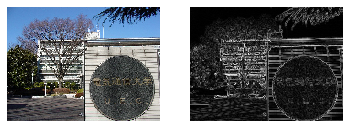

In [6]:
gt = show_image(img, edge, gray)

読み込んだ画像と変換した画像を，numpy形式に変換します．
(h,w,c) h:高さ, w:幅, c:チャネル　のサイズの3次元配列にします．
なお，前回は，(c,h,w) でしたが，Kerasの標準の形式は，(h,w,c) ですので
注意してください．

ここでは画像は320x240で，入力はカラーなので，
input: (240,320,3)
output: (240,320,1)
の大きさです．

In [7]:
def convert_pixel_value(img, gt):
    """
    画素値が [-1,1) の範囲の値になるように変換する関数
    入力
    img: RGBの画像
    gt: エッジ抽出した画像 or グレースケール画像
    
    出力
    input: [-1,1) の範囲の値になるように変換したRGB画像
    output: [-1,1) の範囲の値になるように変換した グレースケール 
            or 
            [-1,1) の範囲の値になるように変換したエッジ抽出をした画像
    """
    # Keras は (h,w,c)が標準ですので，前回の
    #input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
    input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5
    output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5

    # Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
    # 画像１枚での学習なので，batch は 1 です．
    input = input[np.newaxis, ...]               # (240,320,3) -> (1,240,320,3)
    output = output[np.newaxis, ..., np.newaxis] # (230,320) -> (1,240,320,1)
    
    return input, output

In [8]:
# callback のクラス ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,model,max_epoch,test_img):
        # 表示エリアの設定
        self.fig = plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model = model
        self.max_epoch = max_epoch
        self.test_img = test_img
        self.start = time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses = []
        self.n_epoch = []
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.losses.append(logs.get('loss'))
        self.loss = logs.get('loss')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        out = self.model.predict_on_batch(self.test_img)
        self.out = (out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        self.fig2.imshow(self.out,cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch < self.max_epoch - 1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss: {}".format(self.loss))
        print('Time: {}'.format(time.time()-self.start))

畳み込み層を3つ用意します．
3x3x10 -> 3x3x10 -> 3x3x1 です．
1,2層目はReLU付きです．

<a href="https://keras.io/ja/layers/convolutional/#conv2d">Conv2D</a>を利用します．

最初の Conv2Dでは画像入力サイズを指定する必要がありますが，(None,None,3) とすることで，channel数だけを指定して，入力画像サイズは可変とします．
Kerasでは，paddingは値を指定するのではなく，padding あり/なし のどちらかです．padding="same" と指定すると，feature mapのサイズが変化しないように padding の値が自動的にセットされます．

なお，Kerasでのパラメータ初期値の設定方法は，<a href="https://keras.io/ja/initializers/#glorot_uniform">kernel_initializer='glorot_uniform'</a> となっています．Heの初期値がいい場合は，<a href="https://keras.io/ja/initializers/#he_normal">kernel_initializer='he_normal'</a>と指定する必要があります．ここでは，he_normalを指定してみます．

In [9]:
def convolutional_regression_model(is_batch=False, optimizer="momentum_sgd"):
    if is_batch == True:
        model = Sequential()
        model.add(Conv2D(10, 3, padding='same', activation='relu', input_shape=(None, None, 3), kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Conv2D(10, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Conv2D(1, 3, padding='same', kernel_initializer='he_normal'))
        
        if optimizer == "sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0), loss='mean_squared_error')
        elif optimizer == "momentum_sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0) , loss='mean_squared_error')
        elif optimizer == "rmsprop":
            model.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_squared_error')
        elif optimizer == "adam":
            model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
        else:
            raise ValueError("Invalid optimization method")
            
        return model
    
    elif is_batch == False:
        model = Sequential()
        model.add(Conv2D(10, 3, padding='same', activation='relu', input_shape=(None, None, 3), kernel_initializer='he_normal'))
        model.add(Conv2D(10, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model.add(Conv2D(1, 3, padding='same', kernel_initializer='he_normal'))
        
        if optimizer == "sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0), loss='mean_squared_error')
        elif optimizer == "momentum_sgd":
            model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0) , loss='mean_squared_error')
        elif optimizer == "rmsprop":
            model.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_squared_error')
        elif optimizer == "adam":
            model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
        else:
            raise ValueError("Invalid optimization method")
            
        return model

In [10]:
model = convolutional_regression_model()

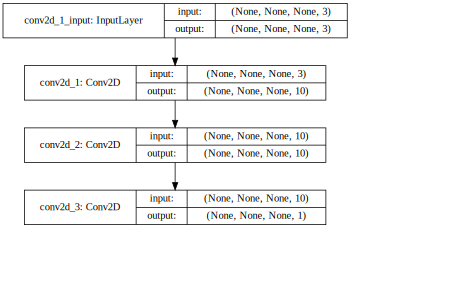

In [11]:
# model の表示
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

学習ループです．
学習率lr = 0.01
エポック数200とします．


In [12]:
input, output = convert_pixel_value(img, gt)

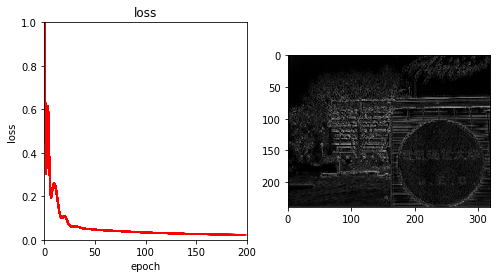

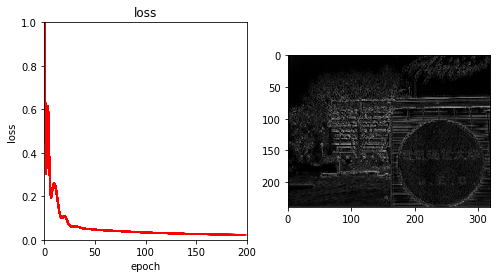

In [13]:
num_epoch = 200
show_graph = ShowGraph(model,num_epoch,input)
model.fit(input, output, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### 課題2
サンプル画像を各自，自分で用意した画像に入れ替えて，以下の小問の(1)-(2)を解答すること．(3)は任意提出の発展課題とする．

1. OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ．
1. (1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．
1. 複数の画像に対応させてみよ．学習画像を2枚, 3枚とするとどうなるか？

学習したモデルで画像を変換（エッジ抽出）してみます．

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 200, 300, 3)
(1, 200, 300, 3) (1, 200, 300, 1)
0.20477384 -1.5482173
0.20477384 -1.0


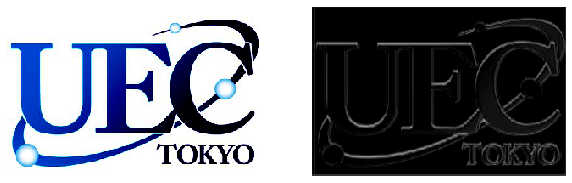

In [14]:
img2 = np.array(Image.open('../figure/uec_mark.jpg').resize((300,200)))
img2 = img2[np.newaxis,...]
img2 = np.array(img2, dtype=np.float32)/127.5-1.0
print(img2.shape)
out = model.predict(img2)
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out = np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out = (out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.axis("off")
plt.imshow(np.squeeze(img2)) # grayscale表示のときは (1,240,320,1)ではNGで，(240,320)になっている必要があります．
plt.subplot(122)
plt.axis("off")
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

### 課題2 1. OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ

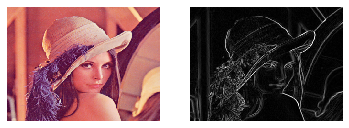

In [15]:
# 自分が用意した画像をエッジ抽出
my_img, my_edge, my_gray = convert_image_to_matrix("../figure/lena.jpg", "sobel")
my_gt = show_image(my_img, my_edge, my_gray)

input_myimg, output_myimg = convert_pixel_value(my_img, my_gt)

### RMSpropを利用した場合

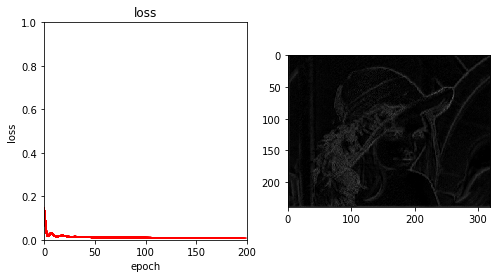

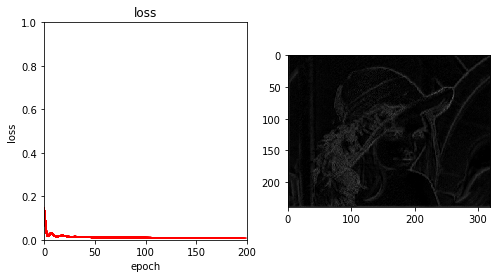

In [16]:
model_rmsprop = convolutional_regression_model(optimizer="rmsprop")

show_graph = ShowGraph(model_rmsprop,num_epoch,input_myimg)
model.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### Adamを利用した場合

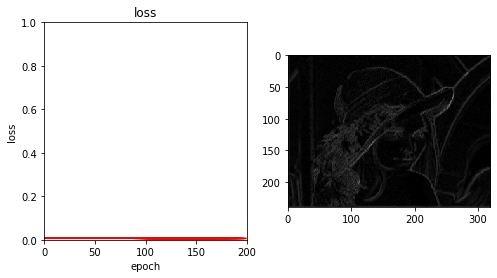

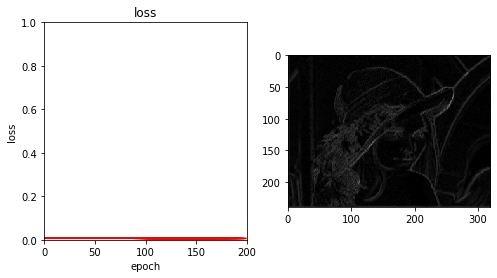

In [17]:
model_adam = convolutional_regression_model(optimizer="adam")

show_graph = ShowGraph(model_adam,num_epoch,input_myimg)
model.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### 課題2 2.(1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．

### 最もlossが小さくなった手法は adam だった．
### Batch Normalization Layerを導入した場合

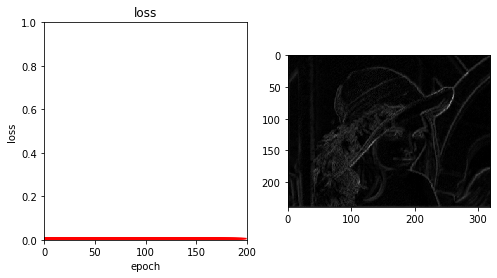

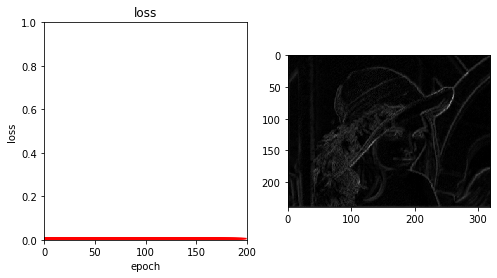

In [18]:
model_adam_with_bn = convolutional_regression_model(optimizer="adam", is_batch=True)

show_graph = ShowGraph(model_adam_with_bn,num_epoch,input_myimg)
model.fit(input_myimg, output_myimg, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph